# Short Text Classification with Over-sampling

NLP service “Bake-Off” on short-text classification of a real-world dataset.

A comparison of the short-text classification performance of a selection of commercial services, open source solutions and common research baselines.

Will cover:

* How well do the commercial NLP APIs perform on a real-world dataset?
* What are the trade-offs of various approaches?
* What should feed into a buy vs. build decision?
* A summary of lessons.

## Objective

Classify short text utterances, such as "Turn off mobile searching", by a defined set of intent categories such as "Service_Management-E_De_Activate_Roaming".

Overall goals of this research include:
* Evaluate commercial services
* Compare against baselines
* Compare against state-of-the-art
* Lessons

Specific challenges include:
* Limited context to learn semantic representations
* Limited data for sophisticated models with a large number of parameters
* Idiosyncratic text, spelling errors, abbreviations, "text speak"

The following general caveats apply:
* This paper focuses on intent classification; not entity extraction. Training both tasks together may yield an improvement.
* These results are pertinent to the specific dataset - your mileage may vary with a different dataset.
* Some methods have procedural constraints, which impact performance. A dataset tailored with these constraints in mind could improve the performance of those methods.
* The services will in all likelihood continue to evolve and improve.

## Related Work

* [Evaluating Natural Language Understanding Services for Conversational Question Answering Systems](http://workshop.colips.org/wochat/@sigdial2017/documents/SIGDIAL22.pdf).

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import classification_report
import sys
import time
import warnings
import zipfile
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# Show TensorFlow errors only
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
sys.path.append('../..')

In [5]:
from text_classification_benchmarks.data_loader import clean_data, load_data
from text_classification_benchmarks.data_loader import remove_classes_with_too_few_examples, tokenize
from text_classification_benchmarks.metrics import perf_summary, print_perf_summary
from text_classification_benchmarks.metrics import perf_by_label, print_perf_by_label
from text_classification_benchmarks.metrics import plot_confusion_matrix, print_best_worst

## About the data

The dataset was created to support a chatbot for customer self-service. It was originally created from a set of suggested intent classes and examples from the product vendor. Testing indicated that the initial dataset was oriented to a North American audience and needed to be localized.

Historical chat logs were analysed to identify frequently occurring intent classes (matched to the feasible scope), and draw examples for those classes from the chat logs.

A team was established to monitor performance in operation. One of the tasks is to identify cases where a conversation is not resolved by the chatbot and determine cause. If the cause is misunderstood intent, then the misclassified utterance is added as a new example, and the model retrained. In this way, the dataset builds up over time.

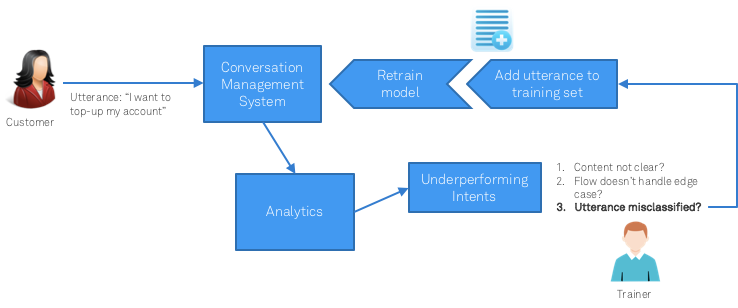

In [6]:
train_df, val_df, test_df, classes = load_data()

Lengths Train: 5696, Val: 633, Test: 703, Classes: 191


Clean data:
    
* Drop classes without an example utterance
* Replace HTML entities and common tags in text

In [7]:
train_df = tokenize(clean_data(train_df))

Length after cleaning data: 5695


In [ ]:
train_df.head()

In [ ]:
train_df.apply(lambda row: pd.Series([row['utterance'], classes[row['label']]], index=['utterance', 'class']), 
               axis=1).head(20)

### Remove classes with too few examples

Necessary for some models.

In [15]:
train_df = remove_classes_with_too_few_examples(train_df, min_examples=5)

Length after processing data: 5680


In [17]:
val_df = clean_data(val_df)

Length after cleaning data: 632


In [ ]:
val_df.head()

In [19]:
val_df = remove_classes_with_too_few_examples(val_df, min_examples=5)

Length after processing data: 346


In [20]:
test_df = clean_data(test_df)

Length after cleaning data: 703


In [21]:
print('Lengths after removing labels with insufficient examples Train: {}, Val: {}, Test: {}'
      .format(len(train_df), len(val_df), len(test_df)))

Lengths after removing labels with insufficient examples Train: 5680, Val: 346, Test: 703


In [ ]:
trainval_df = pd.concat([train_df[['label', 'utterance']], val_df])
trainval_df = trainval_df.reset_index(drop=True)

In [ ]:
len(trainval_df)

In [16]:
print('Number classes after removal:', len(trainval_df.label.unique()))

Number classes after removal: 182


### Tokens per utterance

In [9]:
# Min, Max, Mean, Std Dev. of tokens per utterance
lengths = train_df['length']
print('Min token length: {}, Max: {}, Mean: {}, Std: {}'
      .format(int(lengths.min()), int(lengths.max()), int(lengths.mean()), int(lengths.std())))

Min token length: 1, Max: 70, Mean: 12, Std: 8


In [10]:
char_lengths = train_df.utterance.apply(len)
print('Mean character length:', int(char_lengths.mean()), 'Max length:', char_lengths.max())

Mean character length: 56 Max length: 331


In [11]:
# Variance, Std. Dev. of lengths by label
lengths_by_label = train_df.groupby(['label'])['length']
print('Mean Length by Label Variance: {}, Std: {}'
      .format(int(lengths_by_label.mean().var()), int(lengths_by_label.mean().std())))

Mean Length by Label Variance: 26, Std: 5


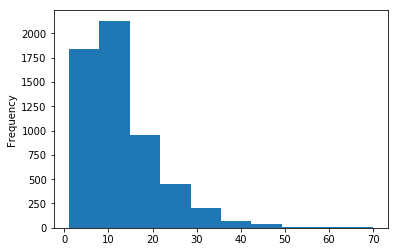

In [12]:
train_df['length'].plot.hist()

### Class Balance

Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration.

In [265]:
counts_by_label = trainval_df.groupby('label').utterance.count()
print('Number Utterances by Label Min: {}, Max: {}, Mean: {}, Std: {}'
      .format(int(counts_by_label.min()), int(counts_by_label.max()), 
              int(counts_by_label.mean()), int(counts_by_label.std())))

Number Utterances by Label Min: 5, Max: 197, Mean: 33, Std: 29


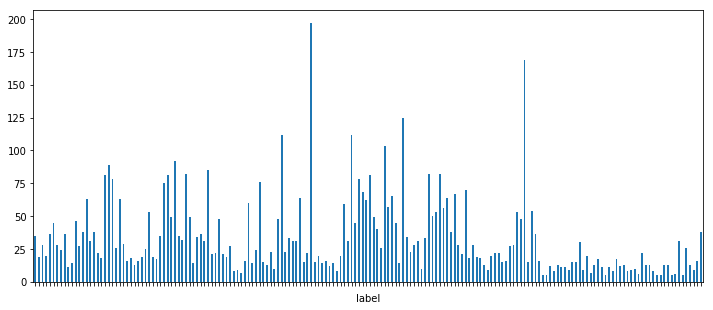

In [266]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
trainval_df.groupby('label').utterance.count().plot.bar(ylim=0)
ax.xaxis.set_major_formatter(plt.NullFormatter())  # hide labels

The dataset is quite imbalanced by class.

Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally.

## Metrics

Options include:
1. Weighted average F1-score (balances precision and recall)
    * Precision - What proportion of positive identifications was actually correct? In other words, how accurate are my predictions? Low precision = too many False Positives.
    * Recall - What proportion of actual positives was identified correctly? In other words, how well did I find all the examples? Low recall = too many False Negatives.
    * Multi-class evaluation uses averages over binary evaluations, per class.
    * Weighted average = macro average weighted by support (number of true instances of each label); takes class imbalance into account.
2. Accuracy  (makes sense if your class labels are uniformly distributed)
3. ROC AUC (Area Under the Receiver Operating Characteristic Curve)
    * Larger area = better able to distinguish between True Positives and True Negatives
4. Multi-class log loss

I have selected Weighted average F1-score as the primary metric.

## Prepare Training, Validation, and Test Sets

In [22]:
columns = ['model', 'precision_weighted_avg', 'recall_weighted_avg', 'f1_weighted_avg', 
           'accuracy', 'roc_auc', 'mean_latency']

In [23]:
X_train, y_train = train_df.utterance, train_df.label
X_val, y_val = val_df.utterance, val_df.label
X_test, y_test = test_df.utterance, test_df.label
n_train, n_val, n_test = len(X_train), len(X_val), len(X_test)
n_total = n_train + n_val + n_test
print('Splits Train: {:.2f}, Val: {:.2f}, Test: {:.2f}'.format(n_train / n_total, n_val / n_total, n_test / n_total))

Splits Train: 0.84, Val: 0.05, Test: 0.10


Limit number of API calls to stay within quotas.

In [24]:
max_api_calls = 5

## Classical models

Bag-of-words features using TF-IDF.

In [25]:
from text_classification_benchmarks.tfidf_bow import generate_tfidf_features, show_relevant_terms

Combine train and val sets to generate features.

In [26]:
features, labels, tfidf, indices = generate_tfidf_features(train_df, val_df, cutoff=5, ngram_range=2)

In [27]:
print('Number Utterances: {}, Features: {}'.format(*features.shape))

Number Utterances: 6026, Features: 1407


*i* utterances represented by *j* features, representing the TF-IDF score for various unigrams and bigrams.

In [ ]:
show_relevant_terms(features, labels, tfidf, classes, every=20)

In [29]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

## Linear Support Vector Classification

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
model = LinearSVC()
model.fit(features, labels)

X_test = tfidf.transform(test_df.utterance).toarray()
y_test = test_df.label
y_pred = model.predict(X_test[:max_api_calls])

In [ ]:
plot_confusion_matrix(y_test[:max_api_calls], y_pred, classes, 0, 20)

In [ ]:
stats = perf_by_label(y_test[:max_api_calls], y_pred, classes, counts_by_label)
print_perf_by_label(stats, rounded=2, sort_column='f1_score')

In [ ]:
print_classification_report(y_test[:max_api_calls], y_pred, classes)

In [ ]:
print_best_worst(stats, rounded=2, sort_column='f1_score', top_n=5, max_name_len=35)

The reported averages are a prevalence-weighted macro-average across classes (equivalent to sklearn's `precision_recall_fscore_support` with `average='weighted'`).

In [65]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.4
Recall (weighted avg)   : 0.4
F1 Score (weighted avg) : 0.4
Accuracy                : 0.4
ROC AUC (macro avg)     : 0.7


In [ ]:
mean_latency = round(model.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

In [66]:
data = dict({'model': 'Linear SVC', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [67]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.4,0.4,0.4,0.4,0.7,0.0032
1,Logistic Regression,0.4,0.4,0.4,0.4,0.7,0.0033
2,Linear SVC,0.4,0.4,0.4,0.4,0.7,0.0000


## Linear SVC with SMOTE Over-sampling

*SMOTE: Synthetic Minority Over-sampling Technique.*

A combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance (in ROC space) than only under-sampling the majority class. 

This method of over-sampling the minority class involves creating synthetic minority class examples.

In [270]:
# !conda install -y -c conda-forge imbalanced-learn

Solving environment: done

## Package Plan ##

  environment location: /Users/d777710/miniconda3/envs/dltemplate_rasa

  added / updated specs: 
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    imbalanced-learn-0.3.3     |             py_1          78 KB  conda-forge

The following NEW packages will be INSTALLED:

    imbalanced-learn: 0.3.3-py_1 conda-forge


imbalanced-learn-0.3 | 78 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [271]:
from imblearn.over_sampling import SMOTE, ADASYN

In [272]:
X_resampled, y_resampled = SMOTE().fit_resample(features, labels)

AttributeError: 'SMOTE' object has no attribute 'fit_resample'

In [ ]:
model_smote = LinearSVC().fit(X_resampled, y_resampled)
y_pred = model_smote.predict(X_test[:max_api_calls])

In [ ]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

In [ ]:
mean_latency = round(model_smote.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

In [ ]:
data = dict({'model': 'Linear SVC with SMOTE Over-sampling', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [ ]:
benchmarks

# Deep Learning Models

## Word-level CNN (Kim 2014)

CNNs have become a modern standard baseline method akin to Naive Bayes models, Support Vector Machine (SVMs) and Logistic Regression.

Originally invented for computer vision, CNN models have subsequently been shown to be effective for NLP and have achieved excellent results in semantic parsing (Yih et al., 2014), search query retrieval (Shen et al., 2014), sentence modeling (Kalchbrenner et al., 2014), and other traditional NLP tasks (Collobert et al., 2011).

The first layer embeds words into low-dimensional vectors. The next layer performs convolutions over the embedded word vectors using multiple filter sizes. For example, sliding over 3, 4 or 5 words at a time. Next, we max-pool the result of the convolutional layer into a long feature vector, add dropout regularization, and classify the result using a softmax layer.

See [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf).

In [188]:
from tensorflow.contrib import learn
import text_classification_benchmarks.word_cnn.util as util

In [189]:
checkpoint_dir = '../word_cnn/runs/1540695350/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [190]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [191]:
x_raw = test_df.utterance.values[:max_api_calls]
x_test = np.array(list(vocab_processor.transform(x_raw)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


In [192]:
tic = time.time()
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)
toc = time.time()

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1540695350/checkpoints/model-17800


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1540695350/checkpoints/model-17800


In [193]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.4
Recall (weighted avg)   : 0.4
F1 Score (weighted avg) : 0.4
Accuracy                : 0.4
ROC AUC (macro avg)     : 0.7


In [194]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.05777697563171387


In [195]:
data = dict({'model': 'Word-level CNN', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [196]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.4,0.4,0.400000,0.4,0.7000,0.003200
1,Logistic Regression,0.4,0.4,0.400000,0.4,0.7000,0.003300
2,Linear SVC,0.4,0.4,0.400000,0.4,0.7000,0.000000
3,NBSVM,0.6,0.6,0.600000,0.6,0.8000,0.350400
4,RASA NLU Spacy-sklearn,0.4,0.4,0.400000,0.4,0.7000,0.015400
5,RASA NLU TensorFlow,0.8,0.8,0.800000,0.8,0.9000,0.013100
6,Snips NLU,0.2,0.2,0.200000,0.2,0.6000,0.015200
7,IBM Watson,0.8,0.8,0.800000,0.8,0.9000,0.229900
8,Google Dialogflow,0.8,0.8,0.800000,0.8,0.9000,1.182700
9,Microsoft LUIS,0.2,0.2,0.200000,0.2,0.6000,0.810000


## Word-level CNN initialised with Word2Vec embeddings

Trains the above CNN initialised with word vectors obtained from an unsupervised neural language model. These vectors were trained by Mikolov et al. (2013) on 100 billion words of Google News. The vectors have dimensionality of 300 and were trained using the continuous bag-of-words
architecture.

We keep the word vectors static and learn only the other parameters of the model.

In [197]:
checkpoint_dir = '../word_cnn/runs/1541065783/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [198]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [199]:
x_raw = test_df.utterance.values[:max_api_calls]
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [200]:
tic = time.time()
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)
toc = time.time()

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541065783/checkpoints/model-17800


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541065783/checkpoints/model-17800


In [201]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.2
Recall (weighted avg)   : 0.2
F1 Score (weighted avg) : 0.2
Accuracy                : 0.2
ROC AUC (macro avg)     : 0.6


A little bit better.

See also [A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1510.03820.pdf).

In [202]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.09120020866394044


In [203]:
data = dict({'model': 'Word-level CNN + Embeddings', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [204]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.4,0.4,0.400000,0.4,0.7000,0.003200
1,Logistic Regression,0.4,0.4,0.400000,0.4,0.7000,0.003300
2,Linear SVC,0.4,0.4,0.400000,0.4,0.7000,0.000000
3,NBSVM,0.6,0.6,0.600000,0.6,0.8000,0.350400
4,RASA NLU Spacy-sklearn,0.4,0.4,0.400000,0.4,0.7000,0.015400
5,RASA NLU TensorFlow,0.8,0.8,0.800000,0.8,0.9000,0.013100
6,Snips NLU,0.2,0.2,0.200000,0.2,0.6000,0.015200
7,IBM Watson,0.8,0.8,0.800000,0.8,0.9000,0.229900
8,Google Dialogflow,0.8,0.8,0.800000,0.8,0.9000,1.182700
9,Microsoft LUIS,0.2,0.2,0.200000,0.2,0.6000,0.810000


### With Embeddings + L2 regularization (l2_reg_lambda = 0.15)

In [205]:
checkpoint_dir = '../word_cnn/runs/1541112212/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [206]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [207]:
x_raw = test_df.utterance.values[:max_api_calls]
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [208]:
tic = time.time()
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)
toc = time.time()

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541112212/checkpoints/model-8900


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541112212/checkpoints/model-8900


In [209]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.0
Recall (weighted avg)   : 0.0
F1 Score (weighted avg) : 0.0
Accuracy                : 0.0
ROC AUC (macro avg)     : 0.5


In [210]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.05578298568725586


In [211]:
data = dict({'model': 'Word-level CNN + Embeddings + L2 Reg', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [212]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.4,0.4,0.400000,0.4,0.7000,0.003200
1,Logistic Regression,0.4,0.4,0.400000,0.4,0.7000,0.003300
2,Linear SVC,0.4,0.4,0.400000,0.4,0.7000,0.000000
3,NBSVM,0.6,0.6,0.600000,0.6,0.8000,0.350400
4,RASA NLU Spacy-sklearn,0.4,0.4,0.400000,0.4,0.7000,0.015400
5,RASA NLU TensorFlow,0.8,0.8,0.800000,0.8,0.9000,0.013100
6,Snips NLU,0.2,0.2,0.200000,0.2,0.6000,0.015200
7,IBM Watson,0.8,0.8,0.800000,0.8,0.9000,0.229900
8,Google Dialogflow,0.8,0.8,0.800000,0.8,0.9000,1.182700
9,Microsoft LUIS,0.2,0.2,0.200000,0.2,0.6000,0.810000


### With Embeddings + higher dropout rate (keep_prob = 0.25)

In [213]:
checkpoint_dir = '../word_cnn/runs/1541241817/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [214]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [215]:
x_raw = test_df.utterance.values[:max_api_calls]
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [216]:
tic = time.time()
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)
toc = time.time()

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541241817/checkpoints/model-8900


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541241817/checkpoints/model-8900


In [217]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.2
Recall (weighted avg)   : 0.2
F1 Score (weighted avg) : 0.2
Accuracy                : 0.2
ROC AUC (macro avg)     : 0.6


In [218]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.05318779945373535


In [219]:
data = dict({'model': 'Word-level CNN + Embeddings + Higher Dropout', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [220]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.4,0.4,0.400000,0.4,0.7000,0.003200
1,Logistic Regression,0.4,0.4,0.400000,0.4,0.7000,0.003300
2,Linear SVC,0.4,0.4,0.400000,0.4,0.7000,0.000000
3,NBSVM,0.6,0.6,0.600000,0.6,0.8000,0.350400
4,RASA NLU Spacy-sklearn,0.4,0.4,0.400000,0.4,0.7000,0.015400
5,RASA NLU TensorFlow,0.8,0.8,0.800000,0.8,0.9000,0.013100
6,Snips NLU,0.2,0.2,0.200000,0.2,0.6000,0.015200
7,IBM Watson,0.8,0.8,0.800000,0.8,0.9000,0.229900
8,Google Dialogflow,0.8,0.8,0.800000,0.8,0.9000,1.182700
9,Microsoft LUIS,0.2,0.2,0.200000,0.2,0.6000,0.810000


## Character-level CNN (Kim et al. 2015)

[Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

Character-level ConvNet is an effective method for text classification without the need for words.

Historically, ConvNets usually require large-scale datasets to work. In this case, it appears to be competitive on our small dataset.

ConvNets may work well for user-generated data. Further analysis is needed to validate the hypothesis that ConvNets are truly good at identifying exotic character combinations such as misspellings and emoticons.

In [221]:
import text_classification_benchmarks.char_cnn.model_setup as setup
import text_classification_benchmarks.char_cnn.util as util

Using TensorFlow backend.


In [222]:
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"\/\\|_@#$%^&*~`+-=<>()[]{}"
input_size = 400
n_classes = len(classes)
x_test_cropped = test_df.utterance.values[:max_api_calls]
y_test_cropped = test_df.label.values[:max_api_calls]

In [223]:
test_data = util.Data(x_test_cropped, y_test_cropped, alphabet, input_size, n_classes)
test_data.load_data()
x_test_onehot, y_test_onehot = test_data.get_all_data()

In [224]:
model = setup.CharCNN(input_size,
                      alphabet_size=69,
                      embedding_size=128,
                      conv_layers=[[256, 10], [256, 7], [256, 5], [256, 3]],
                      fully_connected_layers=[1024, 1024],
                      n_classes=n_classes,
                      keep_prob=0.1,
                      model_filename='../char_cnn/models/weights.best.hdf5',
                      optimizer='adam',
                      loss='categorical_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Loading model at ../char_cnn/models/weights.best.hdf5
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sent_input (InputLayer)          (None, 400)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 400, 128)      8960        sent_input[0][0]                 
____________________________________________________________________________________________________
Conv1D_256_10 (Conv1D)           (None, 391, 256)      327936      embedding_1[0][0]                
____________________________________________________________________________________________________
Conv1D_256_7 (Conv1D)            (None, 394, 256)      229632      embedding_1[0][0]                
___________________________________________________________________________________________

In [225]:
tic = time.time()
preds = model.predict(x_test_onehot, batch_size=128)
toc = time.time()

In [226]:
y_pred = np.argmax(preds, axis=1) + 1

In [227]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.4
Recall (weighted avg)   : 0.4
F1 Score (weighted avg) : 0.4
Accuracy                : 0.4
ROC AUC (macro avg)     : 0.7


In [228]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.026536035537719726


In [229]:
data = dict({'model': 'Char-level CNN', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [230]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.4,0.4,0.400000,0.4,0.7000,0.003200
1,Logistic Regression,0.4,0.4,0.400000,0.4,0.7000,0.003300
2,Linear SVC,0.4,0.4,0.400000,0.4,0.7000,0.000000
3,NBSVM,0.6,0.6,0.600000,0.6,0.8000,0.350400
4,RASA NLU Spacy-sklearn,0.4,0.4,0.400000,0.4,0.7000,0.015400
5,RASA NLU TensorFlow,0.8,0.8,0.800000,0.8,0.9000,0.013100
6,Snips NLU,0.2,0.2,0.200000,0.2,0.6000,0.015200
7,IBM Watson,0.8,0.8,0.800000,0.8,0.9000,0.229900
8,Google Dialogflow,0.8,0.8,0.800000,0.8,0.9000,1.182700
9,Microsoft LUIS,0.2,0.2,0.200000,0.2,0.6000,0.810000


## Bidirectional LSTM (Recurrent Neural Network)

In [231]:
import text_classification_benchmarks.bi_lstm.util as util

In [232]:
# importlib.reload(util)

In [233]:
batch_size = 64
cropped_size = max_api_calls if max_api_calls > batch_size else batch_size
train_labels, train_utterances, train_lengths = util.prepare_data(train_df)
test_labels, test_utterances, test_lengths = util.prepare_data(test_df[:cropped_size])
x_train_indexed, y_train_indexed, train_lengths, x_test_indexed, y_test_indexed, test_lengths, max_length, vocab_size, _ = \
    util.process_data(train_labels, train_utterances, train_lengths, 
                      test_labels, test_utterances, test_lengths, min_frequency=0)

Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


In [234]:
# Training performance
y_pred = util.test(x_train_indexed, y_train_indexed, train_lengths, batch_size=batch_size, 
                   run_dir='../bi_lstm/', checkpoint='clf-8000')

INFO:tensorflow:Restoring parameters from ../bi_lstm/model/clf-8000


INFO:tensorflow:Restoring parameters from ../bi_lstm/model/clf-8000


Test accuracy: 0.38417376882650633


In [235]:
# Test performance
tic = time.time()
y_pred = util.test(x_test_indexed, y_test_indexed, test_lengths, batch_size=batch_size, 
                   run_dir='../bi_lstm/', checkpoint='clf-8000')
toc = time.time()

INFO:tensorflow:Restoring parameters from ../bi_lstm/model/clf-8000


INFO:tensorflow:Restoring parameters from ../bi_lstm/model/clf-8000


Test accuracy: 0.203125


Looks like overfitting. Need a more data!

In [236]:
stats = perf_summary(y_test[:cropped_size], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.17
Recall (weighted avg)   : 0.2
F1 Score (weighted avg) : 0.17
Accuracy                : 0.2
ROC AUC (macro avg)     : 0.6


In [237]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.1513441562652588


In [238]:
data = dict({'model': 'BiLSTM', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [239]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.400000,0.400000,0.400000,0.400000,0.700000,0.003200
1,Logistic Regression,0.400000,0.400000,0.400000,0.400000,0.700000,0.003300
2,Linear SVC,0.400000,0.400000,0.400000,0.400000,0.700000,0.000000
3,NBSVM,0.600000,0.600000,0.600000,0.600000,0.800000,0.350400
4,RASA NLU Spacy-sklearn,0.400000,0.400000,0.400000,0.400000,0.700000,0.015400
5,RASA NLU TensorFlow,0.800000,0.800000,0.800000,0.800000,0.900000,0.013100
6,Snips NLU,0.200000,0.200000,0.200000,0.200000,0.600000,0.015200
7,IBM Watson,0.800000,0.800000,0.800000,0.800000,0.900000,0.229900
8,Google Dialogflow,0.800000,0.800000,0.800000,0.800000,0.900000,1.182700
9,Microsoft LUIS,0.200000,0.200000,0.200000,0.200000,0.600000,0.810000


## Combined CNN and RNN

In [240]:
import common.load_data as load_data
import common.util as data_util
import tf_model.text_classifier.util as util

In [241]:
# importlib.reload(load_data)
# importlib.reload(data_util)
# importlib.reload(util)

In [242]:
constants = {
    'batch_size': 128,
    'keep_prob': 0.5,
    'emb_dim': 300,
    'eval_every': 500,
    'filter_sizes': [3, 4, 5],
    'n_hidden': 300,
    'l2_reg_lambda': 0.0,
    'max_pool_size': 4,
    'non_static': False,
    'n_epochs': 1000,
    'n_filters': 32,
    'learning_rate': 0.001,
    'decay': 0.9
}

In [243]:
# train_df_ = pd.concat([train_df[['label', 'utterance']], val_df])
# train_df_ = train_df_.reset_index(drop=True)
# x_train_, y_train_, vocab, vocab_inv, df, labels = \
#     load_data.prepare_classification_training_set(train_df_, selected=['label', 'utterance'])

In [244]:
# trained_dir = util.train(x_train_, y_train_, vocab, vocab_inv, labels, constants)

In [245]:
TRAINED_DIR = '/Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/notebooks/trained_results_1542333262/'

In [246]:
params, words_index, labels, embedding_mat = util.load_trained_params(TRAINED_DIR)
x_test_, y_test_, df = load_data.prepare_classification_test_set(test_df[:max_api_calls], selected=['utterance'],
                                                                 labels=labels)
tic = time.time()
preds, _, _ = util.predict(x_test_, y_test_, df, params, words_index, labels, embedding_mat, TRAINED_DIR)
toc = time.time()

INFO:root:In prediction, reading trained sequence length...
INFO:root:Max sequence length: 62


seq_len: 62
non_static: False
n_hidden: 300
filter_sizes: [3, 4, 5]
n_filters: 32
emb_dim: 300
max_pool_size: 4
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/notebooks/trained_results_1542333262/best_model


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/notebooks/trained_results_1542333262/best_model
CRITICAL:root:/Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/notebooks/trained_results_1542333262/best_model has been loaded
CRITICAL:root:Prediction complete! Saved to predicted_results_1542333262/.


In [247]:
stats = perf_summary(y_test[:max_api_calls], preds)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.4
Recall (weighted avg)   : 0.4
F1 Score (weighted avg) : 0.4
Accuracy                : 0.4
ROC AUC (macro avg)     : 0.7


In [248]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.6438003540039062


In [249]:
data = dict({'model': 'Combined CNN + RNN', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [250]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.400000,0.400000,0.400000,0.400000,0.700000,0.003200
1,Logistic Regression,0.400000,0.400000,0.400000,0.400000,0.700000,0.003300
2,Linear SVC,0.400000,0.400000,0.400000,0.400000,0.700000,0.000000
3,NBSVM,0.600000,0.600000,0.600000,0.600000,0.800000,0.350400
4,RASA NLU Spacy-sklearn,0.400000,0.400000,0.400000,0.400000,0.700000,0.015400
5,RASA NLU TensorFlow,0.800000,0.800000,0.800000,0.800000,0.900000,0.013100
6,Snips NLU,0.200000,0.200000,0.200000,0.200000,0.600000,0.015200
7,IBM Watson,0.800000,0.800000,0.800000,0.800000,0.900000,0.229900
8,Google Dialogflow,0.800000,0.800000,0.800000,0.800000,0.900000,1.182700
9,Microsoft LUIS,0.200000,0.200000,0.200000,0.200000,0.600000,0.810000


## Transformer

Based on the paper, [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf).

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations.

In [251]:
import tensorflow as tf
import text_classification_benchmarks.transformer.util as util

In [252]:
tf.reset_default_graph()

In [253]:
tic = time.time()
result, labels = util.predict(test_file='../fasttext/test.txt',
                              n_classes=len(classes),
                              learning_rate=0.01,
                              batch_size=256,
                              decay_steps=12000,
                              decay_rate=1.0,
                              seq_len=60,
                              embed_size=300,
                              d_model=300,
                              d_k=64,
                              d_v=64,
                              h=10,
                              n_layers=1,
                              l2_lambda=0.0001,
                              checkpoint_dir='../transformer/trnfmr_model/',
                              vocab_labels_filename='../transformer/labels.txt',
                              word2vec_filename='../../../data/word2vec/GoogleNews-vectors-negative300.bin'
                             )
toc = time.time()

Transformer Classification Vocab size: 500001
Loading data...
test data length: 703
n_examples: 703
Encoding started
Encoding ended. Q: Tensor("layer_normalization_0_encoder_position_wise_ff/add_1:0", shape=(256, 60, 300), dtype=float32), Ks: Tensor("layer_normalization_0_encoder_position_wise_ff/add_1:0", shape=(256, 60, 300), dtype=float32), latency: 0.1480870246887207
Restoring variables from checkpoint
INFO:tensorflow:Restoring parameters from ../transformer/trnfmr_model/model-17


INFO:tensorflow:Restoring parameters from ../transformer/trnfmr_model/model-17


data length: 703
logits_batch shape: (256, 191)
logits_batch shape: (256, 191)


In [254]:
intents = [x[1][0] for x in result]
preds = [list(classes).index(x) for x in intents]
y_true = [list(classes).index(x) for x in labels]

In [255]:
stats = perf_summary(y_true[:max_api_calls], preds[:max_api_calls])
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.4
Recall (weighted avg)   : 0.4
F1 Score (weighted avg) : 0.4
Accuracy                : 0.4
ROC AUC (macro avg)     : 0.7


In [256]:
mean_latency = (toc - tic) / n_test
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.00386834856795722


In [257]:
data = dict({'model': 'Transformer', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [258]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.400000,0.400000,0.400000,0.400000,0.700000,0.003200
1,Logistic Regression,0.400000,0.400000,0.400000,0.400000,0.700000,0.003300
2,Linear SVC,0.400000,0.400000,0.400000,0.400000,0.700000,0.000000
3,NBSVM,0.600000,0.600000,0.600000,0.600000,0.800000,0.350400
4,RASA NLU Spacy-sklearn,0.400000,0.400000,0.400000,0.400000,0.700000,0.015400
5,RASA NLU TensorFlow,0.800000,0.800000,0.800000,0.800000,0.900000,0.013100
6,Snips NLU,0.200000,0.200000,0.200000,0.200000,0.600000,0.015200
7,IBM Watson,0.800000,0.800000,0.800000,0.800000,0.900000,0.229900
8,Google Dialogflow,0.800000,0.800000,0.800000,0.800000,0.900000,1.182700
9,Microsoft LUIS,0.200000,0.200000,0.200000,0.200000,0.600000,0.810000


# Overall Rankings

In [260]:
ranked = benchmarks.sort_values('f1_weighted_avg', ascending=False)
ranked.reset_index(drop=True)

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,RASA NLU TensorFlow,0.800000,0.800000,0.800000,0.800000,0.900000,0.013100
1,IBM Watson,0.800000,0.800000,0.800000,0.800000,0.900000,0.229900
2,Google Dialogflow,0.800000,0.800000,0.800000,0.800000,0.900000,1.182700
3,fastText Classification,0.700000,0.800000,0.733333,0.800000,0.875000,0.000191
4,NBSVM,0.600000,0.600000,0.600000,0.600000,0.800000,0.350400
5,Amazon Lex,0.600000,0.400000,0.466667,0.400000,0.687500,1.066900
6,Logistic Regression,0.400000,0.400000,0.400000,0.400000,0.700000,0.003300
7,Combined CNN + RNN,0.400000,0.400000,0.400000,0.400000,0.700000,0.643800
8,Char-level CNN,0.400000,0.400000,0.400000,0.400000,0.700000,0.026536
9,Word-level CNN,0.400000,0.400000,0.400000,0.400000,0.700000,0.057777


## TODO

1. Stratified sampling for splits